In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [2]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
linkRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,12,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
1,13,240.2424,7.0,1,3.333333,4.666667,314.0,3,False,7.687757,1098.250971
2,14,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,15,142.2112,5.0,1,6.500000,6.500000,366.5,4,False,4.550758,910.151680
4,16,176.1495,6.0,1,7.000000,6.000000,374.0,5,False,5.636784,939.464000
...,...,...,...,...,...,...,...,...,...,...,...
105,894,157.3610,8.0,29,2.333333,3.666667,7465.0,3,True,5.035552,629.444000
106,907,186.1277,8.0,30,4.000000,2.000000,7746.0,3,True,5.956086,744.510800
107,920,170.0694,9.0,30,1.000000,4.000000,7700.0,3,True,5.442221,604.691200
108,922,169.7657,9.0,30,3.000000,4.000000,7732.0,3,True,5.432502,603.611378


In [3]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")




There is a total of 1508 lpGBT links:
 - 1288 singles, and
 - 110 doubles (with one ECOND straddling the pair)



In [4]:

sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
1158,1378,12.1890,5.0,40,15.0,2.0,10482.0,1,False,0.390048,78.009600
1160,1380,12.1951,5.0,40,15.0,4.0,10484.0,1,False,0.390243,78.048640
1162,1382,12.1958,5.0,40,15.0,6.0,10486.0,1,False,0.390266,78.053120
1159,1379,12.1976,5.0,40,15.0,3.0,10483.0,1,False,0.390323,78.064640
1164,1384,12.1992,5.0,40,15.0,8.0,10488.0,1,False,0.390374,78.074880
...,...,...,...,...,...,...,...,...,...,...,...
40,192,461.9141,13.0,7,3.0,0.0,1840.0,3,True,14.781251,1137.019323
13,62,467.5174,13.0,3,3.0,3.0,819.0,3,True,14.960557,1150.812062
12,60,467.6358,13.0,3,3.0,0.0,816.0,3,True,14.964346,1151.103508
24,124,483.2248,13.0,5,3.0,0.0,1328.0,3,True,15.463194,1189.476431


In [5]:
assert( len(sortedRates)%2 == 0 )

In [6]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)

In [7]:
nFPGA = 16 #max=28
#runNumber = 3 #max=4
splitNumber=8

warmStart=False
hardStart=True

#---------------------------------------------------

nGBTSingles = int((1288*nFPGA)/nFPGA)
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = int((110*nFPGA)/nFPGA)
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
#maxSlinkRate = 300
nSlinks = nFPGA*12  #336

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles
maxGBTsPerSlink = 12
SlinkPerFPGA = 12


In [8]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")



Toy problem parameters:
- 1398 lpGBT inputs.
  - 1288 lpGBT singles, and
  - 110 lpGBT doubles.
- 192 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.


 - 16 FPGAs and
 - 12 Slinks served by each FPGA.



In [9]:
def split_dict_equally(input_dict, chunks=2):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list


In [10]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
if nFPGA==nFPGA:
    medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(nGBTSingles/3):-1*int(nGBTSingles/3)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTSingles/3):].to_dict()

lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
if nFPGA==nFPGA:
    medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

#------------------------------------------------------------

lowS_1={}
medS_1={}
highS_1=highS

lowD_1=lowD
medD_1=medD
highD_1=highD

    
#------------------------------------------------------------

if mode=='LtoH':
    medS_1.update(highS_1)
    lowS_1.update(medS_1)
    
    medD_1.update(highD_1)
    lowD_1.update(medD_1)
    
    singleGBTRates_1 = lowS_1
    doubleGBTRates_1 = lowD_1
if mode=='HtoL':
    medS_1.update(lowS_1)
    highS_1.update(medS_1)
    
    medD_1.update(lowD_1)
    highD_1.update(medD_1)
    
    singleGBTRates_1 = highS_1
    doubleGBTRates_1 = highD_1
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]

print(len(singleGBTRates_1))
print(singleGBTRates_1)
print(len(doubleGBTRates_1))
#print(doubleGBTRates_1)



429
{364: 101.6522, 712: 101.7297, 775: 101.7515, 774: 101.75710000000001, 703: 101.79149999999998, 366: 101.8058, 616: 101.85329999999999, 617: 101.9138, 1024: 102.2541, 1025: 102.35079999999999, 1010: 102.49589999999998, 1011: 102.5005, 333: 102.8258, 330: 102.91199999999999, 331: 102.9726, 542: 102.97670000000001, 543: 103.01419999999999, 332: 103.0669, 1119: 103.1788, 1116: 103.2344, 727: 103.2387, 725: 103.3066, 759: 103.6225, 757: 103.7158, 217: 103.9479, 648: 103.98109999999998, 649: 103.9851, 638: 104.067, 216: 104.11319999999999, 373: 104.1889, 639: 104.1986, 372: 104.23060000000001, 914: 104.66792, 915: 104.75259, 553: 104.79920000000001, 552: 104.86320000000002, 969: 104.9403, 26: 104.99390000000001, 970: 105.05099999999999, 27: 105.0616, 956: 105.6527, 955: 105.7606, 457: 105.8179, 455: 105.9285, 454: 105.9863, 456: 106.0684, 663: 106.193, 241: 106.2282, 661: 106.2782, 240: 106.3634, 695: 106.52770000000001, 693: 106.5575, 482: 106.587, 510: 106.64569999999999, 511: 106.712

In [11]:
totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in doubleGBTRates_1.values()]) )

In [12]:
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /len(doubleGBTRates_1)+len(doubleGBTRates_1)}
Average Slink rate: {totalRate / nSlinks}
""")


Total lpGBT rate: 100269.13486999997
Average lpGBT rate: 1021.5375897272725
Average Slink rate: 522.2350774479165



In [13]:
model = pyo.ConcreteModel()

In [14]:
Single1=[str(k) for k in singleGBTRates_1.keys()]
Double1 = [str(k) for k in doubleGBTRates_1.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
#print(Single1)
#print(Double1)
#print(Slink)
#print(FPGA)

In [15]:
model.GKSingles1 = pyo.Var(Single1, Slink, initialize = 0, within = pyo.Binary)
model.GKDoubles1 = pyo.Var(Double1, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)


In [16]:
GKavSlinkRate = (totalRate/nSlinks)
#print(GKavSlinkRate)
model.GKSingles1.fix()
model.GKDoubles1.fix()

In [17]:
#Enter the file path
path = './ScriptRuns/16_fpga_threshold_1500_after_swap_S.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [18]:
print("Average Slink Rate:", GKavSlinkRate)
print("Objective: ", value(model.objective))
model.objective.display()


Average Slink Rate: 522.2350774479165
Objective:  5.840593134816606
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 5.840593134816606


In [19]:
Single2_dict={}
for partNumber in range(9):
    singleGBTRates_2 = split_dict_equally(medS,8)[partNumber-1]

        #print('len(singleGBTRates_2): ',len(singleGBTRates_2))
        #print(singleGBTRates_2)


    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber]=Single2
for partNumber in [1,2]:
    
    singleGBTRates_2 = split_dict_equally(lowS,2)[partNumber-1]
        
    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber+8]=Single2
Single2_dict

{0: ['1273',
  '1179',
  '1289',
  '1185',
  '933',
  '1196',
  '1278',
  '887',
  '1050',
  '1161',
  '1290',
  '714',
  '985',
  '650',
  '1121',
  '1076',
  '797',
  '522',
  '952',
  '1089',
  '431',
  '910',
  '641',
  '576',
  '401',
  '971',
  '902',
  '828',
  '514',
  '1103',
  '993',
  '310',
  '425',
  '643',
  '740',
  '866',
  '679',
  '803',
  '912',
  '1053',
  '392',
  '833',
  '967',
  '710',
  '1055',
  '794',
  '581',
  '432',
  '644',
  '734',
  '826',
  '491',
  '312'],
 1: ['1200',
  '1194',
  '903',
  '1295',
  '1186',
  '1210',
  '1071',
  '1214',
  '1145',
  '683',
  '1158',
  '1221',
  '1169',
  '777',
  '944',
  '587',
  '493',
  '796',
  '674',
  '766',
  '608',
  '704',
  '911',
  '640',
  '1237',
  '861',
  '579',
  '798',
  '916',
  '512',
  '1104',
  '1046',
  '1224',
  '979',
  '642',
  '742',
  '865',
  '926',
  '800',
  '1009',
  '248',
  '390',
  '1236',
  '869',
  '711',
  '1056',
  '551',
  '550',
  '858',
  '647',
  '680',
  '827',
  '519',
  '517

In [20]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [21]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


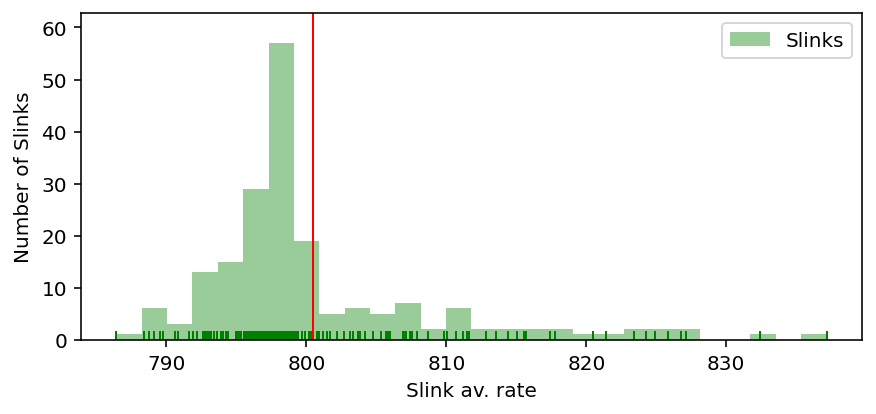

In [22]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
        #ilist -- o vars object için yani run için  GKsingles 2_3  mesela ayrılmış lpgbt rate id ler
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

In [23]:
singleGBTRates_2_ALL={}
singleGBTRates_2_ALL.update(lowS)
singleGBTRates_2_ALL.update(medS)
#singleGBTRates_2_ALL.update()
singleGBTRates_2_ALL
Single2_ALL = [str(k) for k in singleGBTRates_2_ALL.keys()]

totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in singleGBTRates_2_ALL.values()])+sum([i for i in doubleGBTRates_1.values()]) )
GKavSlinkRate = (totalRate/nSlinks)
singleGBTRates_2_ALL

{1378: 12.189,
 1380: 12.1951,
 1382: 12.1958,
 1379: 12.1976,
 1384: 12.1992,
 1386: 12.2023,
 1387: 12.2093,
 1377: 12.2107,
 1385: 12.2131,
 1381: 12.2151,
 1376: 12.2246,
 1383: 12.2254,
 1366: 12.3632,
 1369: 12.3748,
 1368: 12.3769,
 1367: 12.3806,
 1365: 12.3828,
 1370: 12.3908,
 1372: 12.3921,
 1371: 12.3953,
 1373: 12.3994,
 1375: 12.4002,
 1374: 12.4012,
 1364: 12.4063,
 1354: 12.5755,
 1357: 12.5762,
 1362: 12.5774,
 1353: 12.5776,
 1356: 12.5809,
 1359: 12.5811,
 1355: 12.5839,
 1363: 12.5873,
 1358: 12.5907,
 1352: 12.5923,
 1360: 12.5927,
 1361: 12.6002,
 1350: 12.8867,
 1347: 12.8894,
 1346: 12.8947,
 1341: 12.8978,
 1351: 12.9001,
 1343: 12.9046,
 1344: 12.9048,
 1342: 12.9065,
 1348: 12.9106,
 1340: 12.9137,
 1345: 12.9169,
 1349: 12.9256,
 1114: 17.2101,
 1157: 17.2284,
 1402: 19.8778,
 1408: 19.8935,
 1409: 19.8945,
 1405: 19.8996,
 1401: 19.9019,
 1411: 19.9093,
 1403: 19.9098,
 1410: 19.9105,
 1404: 19.9125,
 1407: 19.9135,
 1400: 19.9139,
 1406: 19.918,
 1396: 20.

1
2
3
4
5
6
7
8
1
2


<ipython-input-24-36601bdfb4c3>:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single])
<ipython-input-24-36601bdfb4c3>:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-24-36601bdfb4c3>:91: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


,Slink1,Slink2,Slink3,Slink4,Slink5,Slink6,Slink7,Slink8,Slink9,Slink10,...,Slink183,Slink184,Slink185,Slink186,Slink187,Slink188,Slink189,Slink190,Slink191,Slink192
lpgbt Rates,,,,,,,,,,,,,,,,,,,,,
Single Low,2,3,3,2,3,2,3,4,2,3,...,2,2,1,0,2,2,2,1,1,1
Single Mid,1,2,2,4,2,3,2,1,3,1,...,1,1,3,2,1,1,1,2,2,3
Single High,3,1,3,1,3,3,3,3,3,3,...,4,4,4,4,4,3,4,4,4,4
Double Low,2,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Double Mid,2,2,0,2,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Double High,2,2,0,2,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Total Rate,809,797,795,795,799,789,798,817,796,799,...,798,837,811,799,815,806,815,795,797,825
Slink Total lpGBT,12,10,8,11,8,8,8,8,8,7,...,7,7,8,12,7,12,7,7,7,8


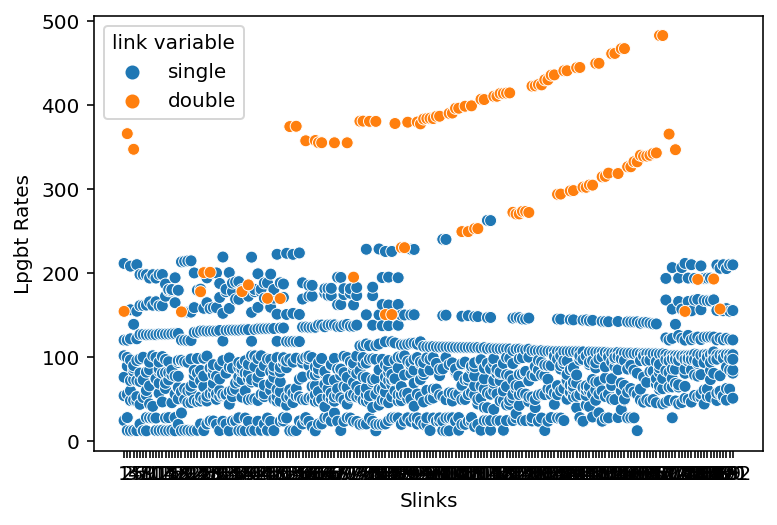

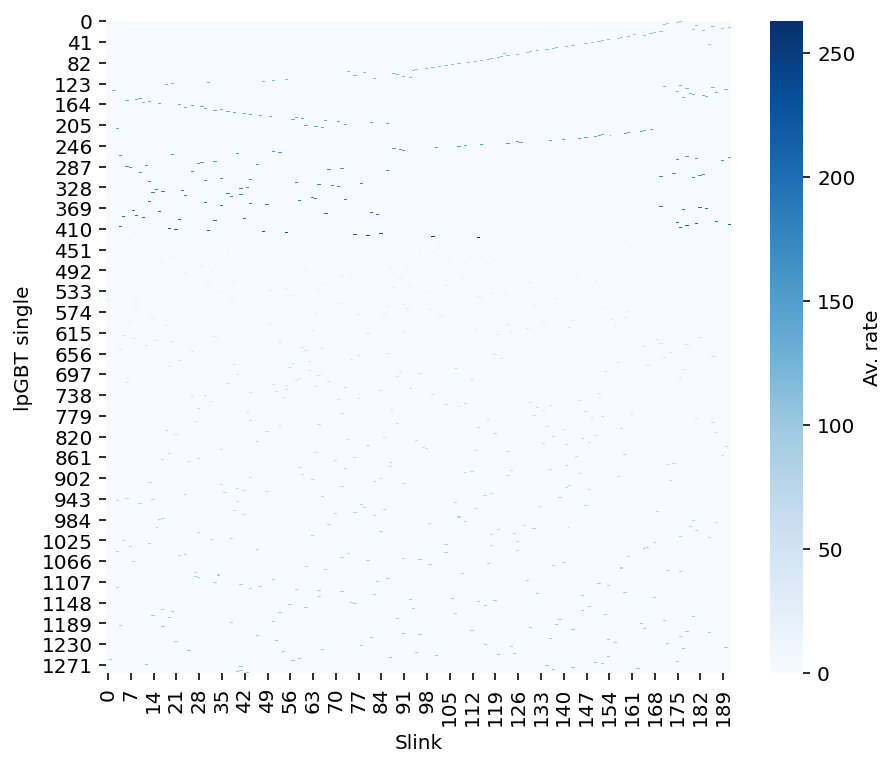

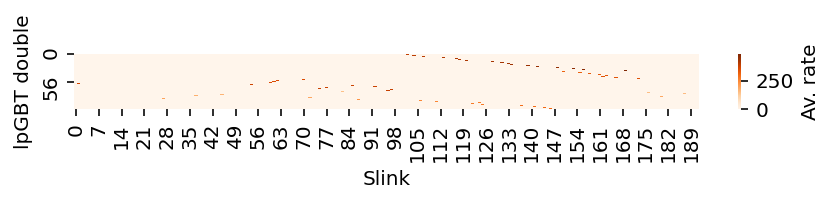

In [24]:
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single.append(a)
hml2_single=np.array([hml_temp_single])

hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double.append(a)
hml2_double=np.array([hml_temp_double])

df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()
#plt.savefig("Swap_Total scatterplot low600 of 28.png")
   

###SİNGLE PART

(wd, ht) = (7, 6)
vmax = max(singleGBTRatesMAIN)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (singles.T * singleGBTRatesMAIN).T,
    cmap='Blues', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT single')

### DOUBLE PART

f, ax = plt.subplots(figsize=(wd, ht * (nGBTDoubles/nGBTSingles)))
vmax = max(doubleGBTRatesMAIN)
sns.heatmap(
    ((doubles.T) * doubleGBTRatesMAIN).T,
    cmap='Oranges', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT double')

### DATAFRAME PART

def create_dataframe():
    hml_double=(doubles.T*doubleGBTRatesMAIN).T
    hml_single=(singles.T * singleGBTRatesMAIN).T
    a=[]
    #slink_lpgbt_total_list=[]
    #slink_lpgbt_total_list2=[]
    for j in range(nSlinks):
        sum_low=0
        sum_mid=0
        sum_high=0
        sum_doub_low=0
        sum_doub_mid=0
        sum_doub_high=0
        list=[]
     
        for i in hml_single[:,j]:
            if i in lowS.values():
                sum_low+=1
        list.append(sum_low)
        for i in hml_single[:,j]:
            if i in medS.values():
                sum_mid+=1
        list.append(sum_mid)
        for i in hml_single[:,j]:
            if i in highS.values():
                sum_high+=1
        list.append(sum_high)
        for i in hml_double[:,j]:
            if i in lowD.values():
                sum_doub_low+=2
        list.append(sum_doub_low)
        for i in hml_double[:,j]:
            if i in medD.values():
                sum_doub_mid+=2
        list.append(sum_doub_mid)
        for i in hml_double[:,j]:
            if i in highD.values():
                sum_doub_high+=2
        list.append(sum_doub_high)
        list.append(int(slink_rate_list[j]))
        slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
        list.append(slink_lpgbt_total)
        #slink_lpgbt_total_list.append([slink_lpgbt_total])
        #slink_lpgbt_total_list2.append(slink_lpgbt_total)

        a.append(list)
    b=np.array(a)
    c=b.T
    tablo=pd.DataFrame(c,index=["Single Low","Single Mid","Single High","Double Low","Double Mid","Double High","Total Rate","Slink Total lpGBT"],
                          columns=["Slink"+str(i+1) for i in range(nSlinks)])
    tablo.index.name="lpgbt Rates"

    return tablo
    #return slink_lpgbt_total_list2
    #return slink_lpgbt_total_list
create_dataframe()#to_csv('lpGBT_Work_Swap_dataframe.csv')


In [25]:
lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
#medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
#len(lowD)
len(medD)
#len(highD)

38

In [26]:
###   slink_lpgbt_total_list work  ###
slink_lpgbt_total_list=[]
slink_lpgbt_total_list2=[]
for j in range(nSlinks):
    sum_low=0
    sum_mid=0
    sum_high=0
    sum_doub_low=0
    sum_doub_mid=0
    sum_doub_high=0
    list=[]
     
    for i in hml_single[:,j]:
        if i in lowS.values():
            sum_low+=1
    list.append(sum_low)
    for i in hml_single[:,j]:
        if i in medS.values():
            sum_mid+=1
    list.append(sum_mid)
    for i in hml_single[:,j]:
        if i in highS.values():
            sum_high+=1
    list.append(sum_high)
    for i in hml_double[:,j]:
        if i in lowD.values():
            sum_doub_low+=2
    list.append(sum_doub_low)
    for i in hml_double[:,j]:
        if i in medD.values():
            sum_doub_mid+=2
    list.append(sum_doub_mid)
    for i in hml_double[:,j]:
        if i in highD.values():
            sum_doub_high+=2
    #list.append(sum_doub_high)
    #list.append(int(slink_rate_list[j]))
    slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
    #list.append(slink_lpgbt_total)
    slink_lpgbt_total_list.append([slink_lpgbt_total])
    slink_lpgbt_total_list2.append(slink_lpgbt_total)
    


In [27]:
sum2_lpgbt=0
for i in slink_lpgbt_total_list2:
    
    sum2_lpgbt+=i
sum2_lpgbt


1508

In [28]:
len(highD)

36

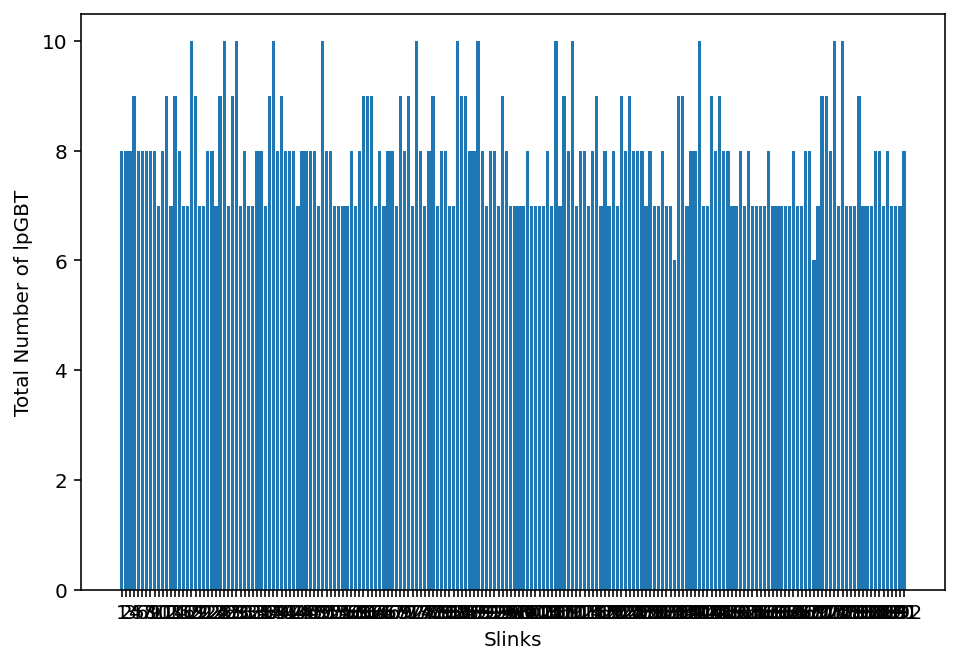

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
Slinks=[str(i) for i in range(1,nSlinks+1)]
lpGBTs = slink_lpgbt_total_list2
ax.set_ylabel('Total Number of lpGBT')
ax.set_xlabel("Slinks")
ax.bar(Slinks,lpGBTs)
#plt.savefig("New Total Number of lpGBT vs Slinks.png")
plt.show()


<BarContainer object of 192 artists>

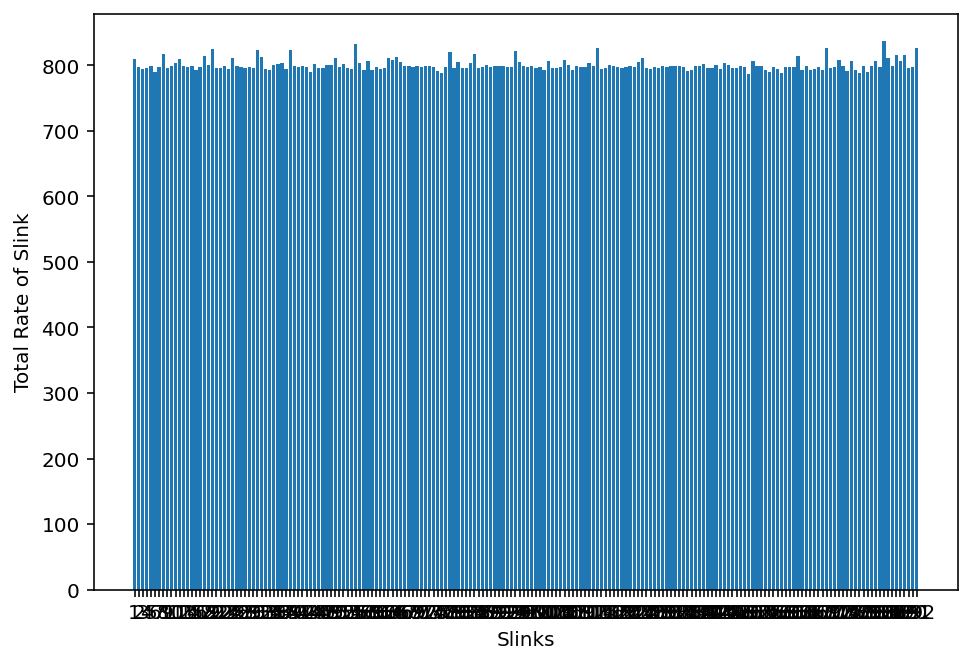

In [30]:
##### Slink Rate vs Slinks
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
Slinks=[str(i) for i in range(1,nSlinks+1)]
Slink_Rates = slink_rate_list
ax.set_ylabel('Total Rate of Slink')
ax.set_xlabel("Slinks")
ax.bar(Slinks,Slink_Rates)
#plt.savefig("New Total Rate of Slink vs Slinks.png",format="png")
#plt.show()


In [31]:

GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
#fpga_rate_list

In [32]:
GK2

{'1': 9621.405250000002,
 '2': 9578.00406,
 '3': 9620.94982,
 '4': 9598.97721,
 '5': 9601.74059,
 '6': 9574.9172,
 '7': 9596.958649999999,
 '8': 9595.07823,
 '9': 9642.42144,
 '10': 9630.470800000001,
 '11': 9564.63391,
 '12': 9648.516510000001,
 '13': 9592.743,
 '14': 9622.90932,
 '15': 9626.166430000001,
 '16': 9576.868260000001}

/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'FPGA av. rate'), Text(0, 0.5, 'Number of FPGAs')]

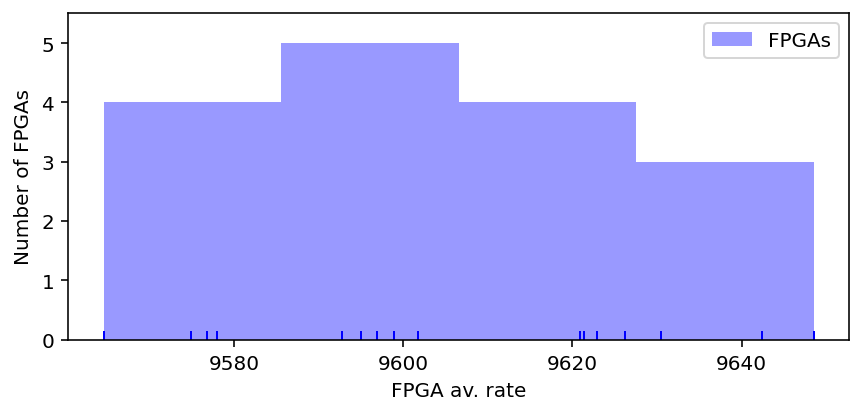

In [33]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')
#plt.savefig("312 EVEN SUNUM New Total Rate of Fpga BEFORE EVETN BUFFER SWAP.png")

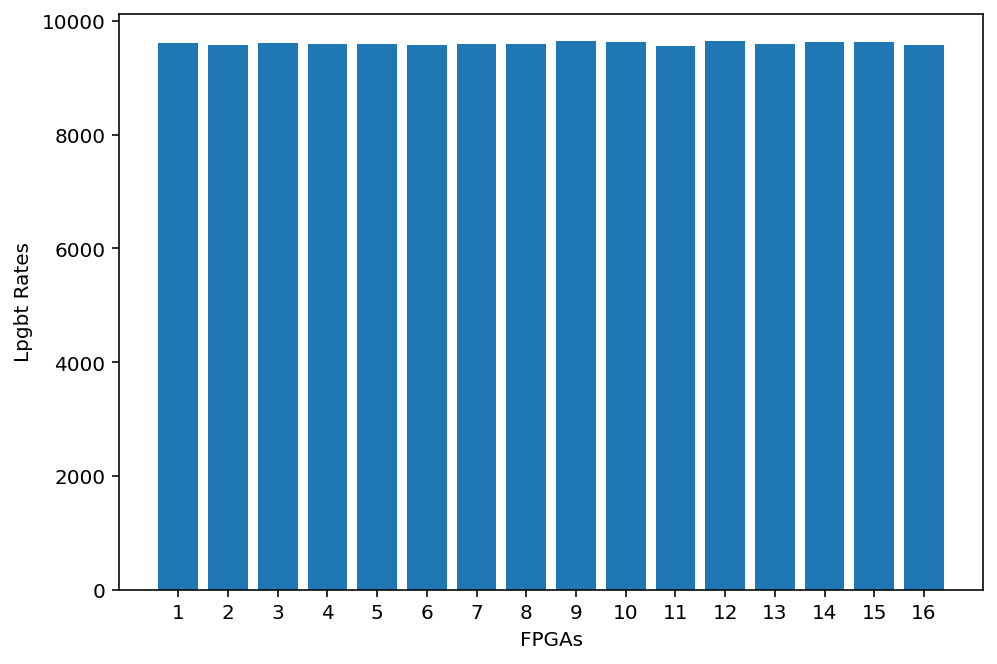

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
FPGAs=[str(i) for i in range(1,nFPGA+1)]
Rates = fpga_rate_list
ax.set_ylabel('Lpgbt Rates')
ax.set_xlabel("FPGAs")
ax.bar(FPGAs,Rates)
#plt.savefig("New Total Rate histogram of Fpga.png")
plt.show()



In [35]:
GK_lpGBT={}
for j in FPGA:
    GK_lpGBT[j] = sum([ slink_lpgbt_total_list2[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_lpGBT_list=[]
for j in GK_lpGBT:
    fpga_lpGBT_list.append(GK_lpGBT[j])
sum_lpgbt=0
for i in fpga_lpGBT_list:
    sum_lpgbt+=i
sum_lpgbt
    

1508.0

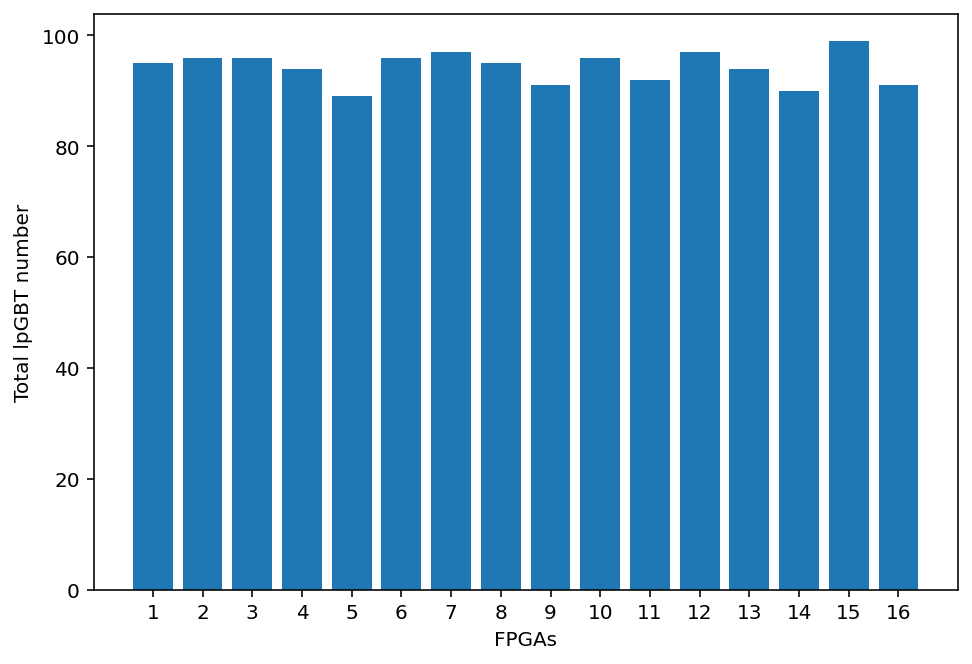

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
FPGAs=[str(i) for i in range(1,nFPGA+1)]
lpGBTs = fpga_lpGBT_list
ax.set_ylabel('Total lpGBT number')
ax.set_xlabel("FPGAs")
ax.bar(FPGAs,lpGBTs)
#plt.savefig("New Total lpGBT Number of Fpgas.png")
plt.show()


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Number of lpGBTs'), Text(0, 0.5, 'Number of FPGAs')]

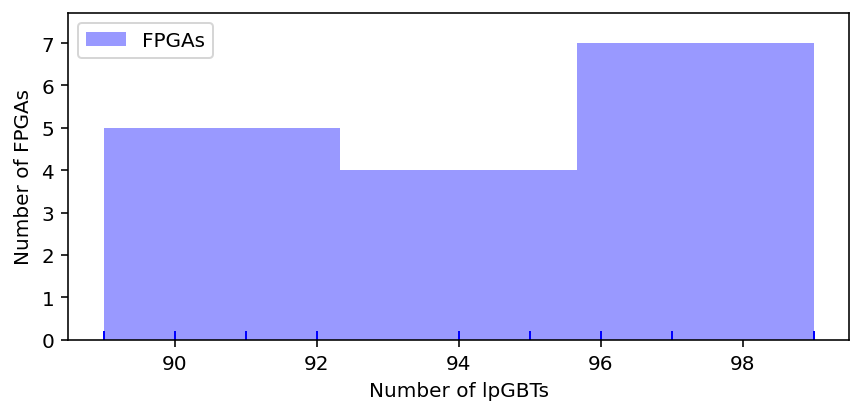

In [37]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_lpGBT_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Number of lpGBTs', ylabel='Number of FPGAs')
#plt.savefig("312 even Total number of lpgbt of Fpga BEFORE EVENT BUFFER SWAP.png")

In [38]:
fpga_lpgbt_dict={}
for i in FPGA:
    fpga_lpgbt_dict[i]=fpga_lpGBT_list[int(i)-1]
fpga_lpgbt_dict

{'1': 95.0,
 '2': 96.0,
 '3': 96.0,
 '4': 94.0,
 '5': 89.0,
 '6': 96.0,
 '7': 97.0,
 '8': 95.0,
 '9': 91.0,
 '10': 96.0,
 '11': 92.0,
 '12': 97.0,
 '13': 94.0,
 '14': 90.0,
 '15': 99.0,
 '16': 91.0}

In [39]:
slink_lpgbt_dict={}
for i in Slink:
    slink_lpgbt_dict[i]=slink_lpgbt_total_list2[int(i)-1]
slink_lpgbt_dict

{'1': 8,
 '2': 8,
 '3': 8,
 '4': 9,
 '5': 8,
 '6': 8,
 '7': 8,
 '8': 8,
 '9': 8,
 '10': 7,
 '11': 8,
 '12': 9,
 '13': 7,
 '14': 9,
 '15': 8,
 '16': 7,
 '17': 7,
 '18': 10,
 '19': 9,
 '20': 7,
 '21': 7,
 '22': 8,
 '23': 8,
 '24': 7,
 '25': 9,
 '26': 10,
 '27': 7,
 '28': 9,
 '29': 10,
 '30': 7,
 '31': 8,
 '32': 7,
 '33': 7,
 '34': 8,
 '35': 8,
 '36': 7,
 '37': 9,
 '38': 10,
 '39': 8,
 '40': 9,
 '41': 8,
 '42': 8,
 '43': 8,
 '44': 7,
 '45': 8,
 '46': 8,
 '47': 8,
 '48': 8,
 '49': 7,
 '50': 10,
 '51': 8,
 '52': 8,
 '53': 7,
 '54': 7,
 '55': 7,
 '56': 7,
 '57': 8,
 '58': 7,
 '59': 8,
 '60': 9,
 '61': 9,
 '62': 9,
 '63': 7,
 '64': 8,
 '65': 7,
 '66': 8,
 '67': 8,
 '68': 7,
 '69': 9,
 '70': 8,
 '71': 9,
 '72': 7,
 '73': 10,
 '74': 8,
 '75': 7,
 '76': 8,
 '77': 9,
 '78': 7,
 '79': 8,
 '80': 8,
 '81': 7,
 '82': 7,
 '83': 10,
 '84': 9,
 '85': 9,
 '86': 8,
 '87': 8,
 '88': 10,
 '89': 8,
 '90': 7,
 '91': 8,
 '92': 8,
 '93': 7,
 '94': 9,
 '95': 8,
 '96': 7,
 '97': 7,
 '98': 7,
 '99': 7,
 '100': 8,


In [40]:
FPGA_temp=[]
for i in range(1,29):
    FPGA_temp.append(str(i))
FPGA_temp

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28']

In [41]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97': 3

In [42]:
#### LPGBT +ID WORK   #### LPGBT RATE PART
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single_RATE.append(a)
hml2_single=np.array([hml_temp_single_RATE])

hml_temp_double_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double_RATE.append(a)
hml2_double=np.array([hml_temp_double_RATE])
hml_temp_double_RATE


1
2
3
4
5
6
7
8
1
2


<ipython-input-42-17ce7cb10a28>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single_RATE])
<ipython-input-42-17ce7cb10a28>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double_RATE])


[[154.5439],
 [366.3132],
 [],
 [347.669],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [153.937],
 [],
 [],
 [],
 [],
 [],
 [177.91719999999998],
 [200.6861],
 [],
 [201.0758],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [178.1644],
 [],
 [186.1277],
 [],
 [],
 [],
 [],
 [],
 [170.0694],
 [],
 [],
 [],
 [169.7657],
 [],
 [],
 [374.7344],
 [],
 [375.1077],
 [],
 [],
 [357.8139],
 [],
 [],
 [358.14390000000003],
 [355.5475],
 [355.5097],
 [],
 [],
 [],
 [355.4363],
 [],
 [],
 [],
 [355.4081],
 [],
 [195.29819999999998],
 [],
 [381.1565],
 [381.24199999999996],
 [],
 [380.987],
 [],
 [380.9151],
 [],
 [],
 [150.7394],
 [],
 [150.71790000000001],
 [378.3944],
 [],
 [230.55130000000003],
 [230.4247],
 [379.9456],
 [],
 [],
 [380.15389999999996],
 [377.9358],
 [383.7639],
 [384.31600000000003],
 [384.6464],
 [384.2873],
 [386.87809999999996],
 [387.0361],
 [],
 [],
 [390.49379999999996],
 [390.85830000000004],
 [396.479],
 [396.58900000000006],
 [249.597500000000

In [43]:
#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
#sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()

1
2
3
4
5
6
7
8
1
2


<ipython-input-43-7709cc67c55d>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-43-7709cc67c55d>:115: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [44]:
###### ID AND LPGBT RATES TOGETHER #### +++++ SWAPPED FPGA SSS






#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i],"lpGBT Rates":hml_temp_double_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Id":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i]),"lpGBT Rates":hml_temp_single_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)

1
2
3
4
5
6
7
8
1
2


<ipython-input-44-c5c49bc1cbfb>:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-44-c5c49bc1cbfb>:122: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [45]:
#df_together.to_csv("312 even.csv")
df_together

,Slinks,Lpgbt Id,link variable,Total lpGBT of Slinks,total rate,lpGBT Rates,FPGA,Total lpGBT of FPGA,Total Rate of FPGA
0,1,364,single,8.0,809.84770,101.65220,15.0,99.0,9626.16643
1,1,242,single,8.0,809.84770,120.31110,15.0,99.0,9626.16643
2,1,72,single,8.0,809.84770,211.62750,15.0,99.0,9626.16643
3,1,1415,single,8.0,809.84770,24.42700,15.0,99.0,9626.16643
4,1,659,single,8.0,809.84770,54.05150,15.0,99.0,9626.16643
5,1,896,single,8.0,809.84770,76.06640,15.0,99.0,9626.16643
6,2,399,single,8.0,797.50820,120.27660,12.0,97.0,9648.51651
7,2,1354,single,8.0,797.50820,12.57550,12.0,97.0,9648.51651
8,2,1462,single,8.0,797.50820,27.98600,12.0,97.0,9648.51651
9,2,1151,single,8.0,797.50820,55.73383,12.0,97.0,9648.51651


In [46]:
def total_buffer_of_fpga(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    #return connected_slinks
  
    #for k in connected_slinks:
        #print(slink_lpgbt_dict[k])
    #return connected_slinks
    
    total_buffer=0
    for j in connected_slinks:
        if slink_lpgbt_dict[j]%2==0:
            event=slink_lpgbt_dict[j]/2
            total_buffer+=event
        else:
            event=(slink_lpgbt_dict[j]+1)/2
            total_buffer+=event
    
    return total_buffer
def connected_slinks(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    return connected_slinks
    
    

In [48]:
#total_buffer_of_fpga('26')
connected_slinks('14')


['12', '15', '32', '49', '68', '85', '103', '133', '151', '166', '184', '190']

In [49]:
buffer_fpga_dict={}
for fpga in FPGA:
    buffer_fpga_dict[fpga]=total_buffer_of_fpga(fpga)
buffer_fpga_dict


{'1': 50.0,
 '2': 53.0,
 '3': 52.0,
 '4': 49.0,
 '5': 48.0,
 '6': 52.0,
 '7': 52.0,
 '8': 50.0,
 '9': 50.0,
 '10': 51.0,
 '11': 49.0,
 '12': 50.0,
 '13': 52.0,
 '14': 50.0,
 '15': 51.0,
 '16': 48.0}

In [50]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [51]:
def total_buffer_of_slink(slink):
    if slink_lpgbt_dict[slink]%2==0:
        event=(slink_lpgbt_dict[slink])/2
    else:
        event=(slink_lpgbt_dict[slink]+1)/2
    return event
    

In [53]:
total_buffer_of_slink('130')

4.0

In [54]:
buffer_slink_dict={}
for slink in Slinks:
    buffer_slink_dict[slink]=total_buffer_of_slink(slink)
buffer_slink_dict

{'1': 4.0,
 '2': 4.0,
 '3': 4.0,
 '4': 5.0,
 '5': 4.0,
 '6': 4.0,
 '7': 4.0,
 '8': 4.0,
 '9': 4.0,
 '10': 4.0,
 '11': 4.0,
 '12': 5.0,
 '13': 4.0,
 '14': 5.0,
 '15': 4.0,
 '16': 4.0,
 '17': 4.0,
 '18': 5.0,
 '19': 5.0,
 '20': 4.0,
 '21': 4.0,
 '22': 4.0,
 '23': 4.0,
 '24': 4.0,
 '25': 5.0,
 '26': 5.0,
 '27': 4.0,
 '28': 5.0,
 '29': 5.0,
 '30': 4.0,
 '31': 4.0,
 '32': 4.0,
 '33': 4.0,
 '34': 4.0,
 '35': 4.0,
 '36': 4.0,
 '37': 5.0,
 '38': 5.0,
 '39': 4.0,
 '40': 5.0,
 '41': 4.0,
 '42': 4.0,
 '43': 4.0,
 '44': 4.0,
 '45': 4.0,
 '46': 4.0,
 '47': 4.0,
 '48': 4.0,
 '49': 4.0,
 '50': 5.0,
 '51': 4.0,
 '52': 4.0,
 '53': 4.0,
 '54': 4.0,
 '55': 4.0,
 '56': 4.0,
 '57': 4.0,
 '58': 4.0,
 '59': 4.0,
 '60': 5.0,
 '61': 5.0,
 '62': 5.0,
 '63': 4.0,
 '64': 4.0,
 '65': 4.0,
 '66': 4.0,
 '67': 4.0,
 '68': 4.0,
 '69': 5.0,
 '70': 4.0,
 '71': 5.0,
 '72': 4.0,
 '73': 5.0,
 '74': 4.0,
 '75': 4.0,
 '76': 4.0,
 '77': 5.0,
 '78': 4.0,
 '79': 4.0,
 '80': 4.0,
 '81': 4.0,
 '82': 4.0,
 '83': 5.0,
 '84': 5.0,
 

In [55]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97': 3

In [56]:
buffer_fpga_dict

{'1': 50.0,
 '2': 53.0,
 '3': 52.0,
 '4': 49.0,
 '5': 48.0,
 '6': 52.0,
 '7': 52.0,
 '8': 50.0,
 '9': 50.0,
 '10': 51.0,
 '11': 49.0,
 '12': 50.0,
 '13': 52.0,
 '14': 50.0,
 '15': 51.0,
 '16': 48.0}

In [57]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer

807.0

In [58]:
for i in FPGA:
    if model.GKSlinks['132',i]==1:
        print(i)

13


In [63]:
##### SECONDARY SWAP #### + FPGA TOTAL RATE  burann kodu bu

### NOW SWAP ALGORİTHM FOR FPGA BUFFER after OPTİMİZASYON###
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    if buffer_fpga_dict[fpga]>50:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        #print(fpga1)
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            #highest_buffer_slink=slink
            #break
            if buffer_slink_dict[slink]>temp_slink: 
                temp_slink=buffer_slink_dict[slink]
                highest_buffer_slink=slink
                if GK[slink]<temp_rate:
                    temp_slink=buffer_slink_dict[slink]
                    highest_buffer_slink=slink
                    #print(temp_slink)
                    
                    #temp_rate=GK[slink]
            #else:
                #continue
        #key_value=buffer
        lowest_buffer_fpga=10000
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<50):# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                #print('other fpga:',fpga2)
                #FLAG=1
                
            #else:
                #continue
                
                temp_rate2=100000
                for k in connected_slinks(fpga2_temp):# find the lowest buffer slink in lower buffer fpga 
                    key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                    #key_value=buffer_fpga_dict[fpga1]-30
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])
                    #print('key value ok',key_value)
                    
                    
                    if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                        #buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]>=buffer_fpga_dict[fpga1]-30  and 
                        #temp_slink=buffer_slink_dict[k]
                        #key_value==buffer_fpga_dict[fpga1]-30
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        #if (buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                        lowest_buffer_slink=k
                        temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                        #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                        FLAG=1
                        #print('FLAG:',FLAG)
                        #if GK[k]<temp_rate2:
                            #lowest_buffer_slink=k
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                            #FLAG=1
                            
                        
                    #else:
                        #continue
                        #FLAG=1
        
        
        #now change the slinks
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0
            
            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
        

In [64]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [65]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [76]:
''''if model.GKSlinks['132','1']==1:
    print('ok')
elif model.GKSlinks['132','7']==1:
    print('not ok')
elif model.GKSlinks['132','26']==1:
    print('26da kanka')

26da kanka


In [59]:
for i in FPGA:
    if model.GKSlinks['132',i]==1:
        print(i)

1


In [70]:
''''model.GKSlinks['132','7']=0
model.GKSlinks['132','1']=0

In [71]:
''''model.GKSlinks['132','26']=1

In [72]:
''''buffer_fpga_dict['1']=total_buffer_of_fpga('1')
buffer_fpga_dict['26']=total_buffer_of_fpga('26')
buffer_fpga_dict['7']=total_buffer_of_fpga('7')

In [66]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 11,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 5,
 '19': 16,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 16,
 '27': 13,
 '28': 7,
 '29': 4,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 10,
 '37': 5,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97':

In [74]:
''''
for j in Slinks:
    sum1=0
    for i in FPGA:
    #model.GKSlinks['132','26']=1
        if model.GKSlinks[j,i]==1:
            sum1+=1
            #print(sum)
            list1.append(sum1)
            if sum1!=1:
                print(j)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-74-449389d08164>, line 11)

In [67]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [69]:
key_event=total_buffer/nFPGA
key_event

50.4375

In [59]:
''''##### EVENT BUFFER 30 LARI ELE #####
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    
    if buffer_fpga_dict[fpga]>30:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            highest_buffer_slink=slink
            #break
            #if buffer_slink_dict[slink]>temp_slink: 
                #temp_slink=buffer_slink_dict[slink]
                #highest_buffer_slink=slink
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga])<30: #>int(key_event)) and buffer_fpga_dict[other_fpga]<30:# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2=other_fpga
        temp_rate=100000       #print('other fpga:',fpga2)
        for k in connected_slinks(fpga2):
            key_rate=abs(GK[highest_buffer_slink]-GK[k])
            
            if buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]==1 and key_rate<temp_rate:
                lowest_buffer_slink=k
                temp_rate=abs(GK[highest_buffer_slink]-GK[k])
                FLAG=1
                
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
            
                
                

In [70]:
##### EVENT BUFFER I ORTALAMAYA YAKLAŞTIR #####
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    
    if buffer_fpga_dict[fpga]<int(key_event):
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            highest_buffer_slink=slink
            #break
            #if buffer_slink_dict[slink]>temp_slink: 
                #temp_slink=buffer_slink_dict[slink]
                #highest_buffer_slink=slink
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga])==51: #>int(key_event)) and buffer_fpga_dict[other_fpga]<30:# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                temp_rate=100000       #print('other fpga:',fpga2)
                for k in connected_slinks(fpga2_temp):
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])

                    if buffer_slink_dict[k]-buffer_slink_dict[highest_buffer_slink]==1 and key_rate<temp_rate:
                        lowest_buffer_slink=k
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        FLAG=1
                
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
            
                
                

In [71]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [72]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [73]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [80]:
for i in connected_slinks('3'):
    #ev=buffer_slink_dict[i]
    print(i)#total_buffer_of_fpga('2')

11
19
80
119
145
151
192
211
237
240
265
298


In [63]:
if model.GKSlinks['99','1']==1:
    print('ok')


In [74]:
buffer_slink_dict['67']

3.0

In [78]:
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict['2']=total_buffer_of_fpga('2')
            buffer_fpga_dict['3']=total_buffer_of_fpga('3')

In [66]:
''''##### SECONDARY SWAP #### + FPGA TOTAL RATE

### NOW SWAP ALGORİTHM FOR FPGA BUFFER after OPTİMİZASYON###
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    if buffer_fpga_dict[fpga]>30:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            if buffer_slink_dict[slink]>temp_slink: 
                temp_slink=buffer_slink_dict[slink]
                highest_buffer_slink=slink
                #if GK[slink]<temp_rate:
                    #temp_slink=buffer_slink_dict[slink]
                    #highest_buffer_slink=slink
                    
                    #temp_rate=GK[slink]
            #else:
                #continue
        #key_value=buffer
        lowest_buffer_fpga=10000
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<30) and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2=other_fpga
                #FLAG=1
                
            #else:
                #continue
                
                temp_rate2=100000
                for k in connected_slinks(fpga2):# find the lowest buffer slink in lower buffer fpga 
                    key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                    #key_value=buffer_fpga_dict[fpga1]-30
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])
                    
                    
                    if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                        #key_value>=buffer_fpga_dict[fpga1]-30 and key_value<=30-buffer_fpga_dict[fpga2] 
                        #temp_slink=buffer_slink_dict[k]
                        
                    #if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                        #temp_slink=buffer_slink_dict[k]
                        #(buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                        lowest_buffer_slink=k
                        temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                        #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                        FLAG=1
                        #if GK[k]<temp_rate2:
                            #lowest_buffer_slink=k
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                            #FLAG=1
                            
                        
                    #else:
                        #continue
                        #FLAG=1
        
        
        #now change the slinks
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0
            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)

In [74]:
GK_lpGBT={}
for j in FPGA:
    GK_lpGBT[j] = sum([ slink_lpgbt_total_list2[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_lpGBT_list=[]
for j in GK_lpGBT:
    fpga_lpGBT_list.append(GK_lpGBT[j])
#fpga_lpGBT_list
fpga_lpgbt_dict={}
for i in FPGA:
    fpga_lpgbt_dict[i]=fpga_lpGBT_list[int(i)-1]
fpga_lpgbt_dict

{'1': 95.0,
 '2': 94.0,
 '3': 94.0,
 '4': 97.0,
 '5': 94.0,
 '6': 94.0,
 '7': 94.0,
 '8': 95.0,
 '9': 91.0,
 '10': 94.0,
 '11': 94.0,
 '12': 97.0,
 '13': 91.0,
 '14': 90.0,
 '15': 99.0,
 '16': 95.0}

In [75]:

GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list_swap=[]
for j in GK2:
    fpga_rate_list_swap.append(GK2[j])
#fpga_rate_list_swap
GK2

{'1': 9621.405250000002,
 '2': 9575.92322,
 '3': 9620.74865,
 '4': 9599.257169999999,
 '5': 9602.60073,
 '6': 9574.65462,
 '7': 9597.56822,
 '8': 9595.07823,
 '9': 9642.42144,
 '10': 9629.00109,
 '11': 9564.896490000001,
 '12': 9648.516510000001,
 '13': 9592.46304,
 '14': 9622.90932,
 '15': 9626.166430000001,
 '16': 9579.150270000002}

In [76]:
#### LPGBT +ID WORK   #### LPGBT RATE PART
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single_RATE.append(a)
hml2_single=np.array([hml_temp_single_RATE])

hml_temp_double_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double_RATE.append(a)
hml2_double=np.array([hml_temp_double_RATE])
hml_temp_double_RATE


1
2
3
4
5
6
7
8
1
2


<ipython-input-76-17ce7cb10a28>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single_RATE])
<ipython-input-76-17ce7cb10a28>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double_RATE])


[[154.5439],
 [366.3132],
 [],
 [347.669],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [153.937],
 [],
 [],
 [],
 [],
 [],
 [177.91719999999998],
 [200.6861],
 [],
 [201.0758],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [178.1644],
 [],
 [186.1277],
 [],
 [],
 [],
 [],
 [],
 [170.0694],
 [],
 [],
 [],
 [169.7657],
 [],
 [],
 [374.7344],
 [],
 [375.1077],
 [],
 [],
 [357.8139],
 [],
 [],
 [358.14390000000003],
 [355.5475],
 [355.5097],
 [],
 [],
 [],
 [355.4363],
 [],
 [],
 [],
 [355.4081],
 [],
 [195.29819999999998],
 [],
 [381.1565],
 [381.24199999999996],
 [],
 [380.987],
 [],
 [380.9151],
 [],
 [],
 [150.7394],
 [],
 [150.71790000000001],
 [378.3944],
 [],
 [230.55130000000003],
 [230.4247],
 [379.9456],
 [],
 [],
 [380.15389999999996],
 [377.9358],
 [383.7639],
 [384.31600000000003],
 [384.6464],
 [384.2873],
 [386.87809999999996],
 [387.0361],
 [],
 [],
 [390.49379999999996],
 [390.85830000000004],
 [396.479],
 [396.58900000000006],
 [249.597500000000

In [77]:
#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
#sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()

1
2
3
4
5
6
7
8
1
2


<ipython-input-77-7709cc67c55d>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-77-7709cc67c55d>:115: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [78]:
###### ID AND LPGBT RATES TOGETHER #### +++++ SWAPPED FPGA SSS






#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i],"lpGBT Rates":hml_temp_double_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Event-Buffer":buffer_fpga_dict[str(slinks_to_fpga[str(i+1)])],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Id":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i]),"lpGBT Rates":hml_temp_single_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Event-Buffer":buffer_fpga_dict[str(slinks_to_fpga[str(i+1)])],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)

1
2
3
4
5
6
7
8
1
2


<ipython-input-78-bd7f93ba4614>:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-78-bd7f93ba4614>:122: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [79]:
df_together.to_csv('312 even event-buffer_YAKLAŞTIRMA+after better swap.csv')
df_together#.to_csv('312 just Second Swap event-buffer+rate.csv')

,Slinks,Lpgbt Id,link variable,Total lpGBT of Slinks,total rate,lpGBT Rates,FPGA,Event-Buffer,Total lpGBT of FPGA,Total Rate of FPGA
0,1,364,single,8.0,809.84770,101.65220,15.0,51.0,99.0,9626.16643
1,1,242,single,8.0,809.84770,120.31110,15.0,51.0,99.0,9626.16643
2,1,72,single,8.0,809.84770,211.62750,15.0,51.0,99.0,9626.16643
3,1,1415,single,8.0,809.84770,24.42700,15.0,51.0,99.0,9626.16643
4,1,659,single,8.0,809.84770,54.05150,15.0,51.0,99.0,9626.16643
5,1,896,single,8.0,809.84770,76.06640,15.0,51.0,99.0,9626.16643
6,2,399,single,8.0,797.50820,120.27660,12.0,50.0,97.0,9648.51651
7,2,1354,single,8.0,797.50820,12.57550,12.0,50.0,97.0,9648.51651
8,2,1462,single,8.0,797.50820,27.98600,12.0,50.0,97.0,9648.51651
9,2,1151,single,8.0,797.50820,55.73383,12.0,50.0,97.0,9648.51651


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


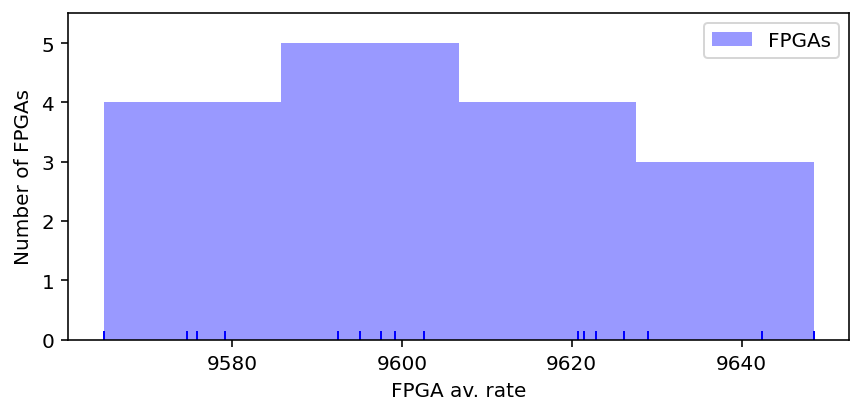

In [80]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list_swap,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')
plt.savefig("312 YAKLAŞTIRMA even after event buffer swap total rate+AFTER BETTER SWAP.png")


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


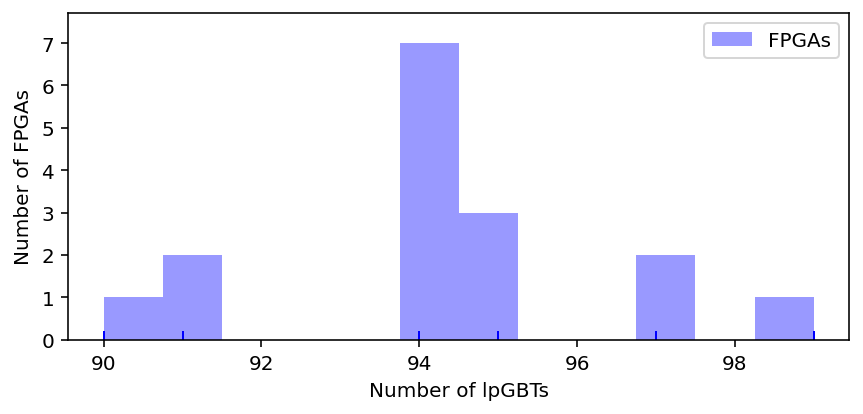

In [81]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_lpGBT_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Number of lpGBTs', ylabel='Number of FPGAs')
plt.savefig("312 YAKLAŞTIRMA event buffer swap LPGBT NUMBER +AFTER BETTER SWAP.png")